<a href="https://colab.research.google.com/github/SevilayMuni/e-commerce-fraud-detection/blob/main/e_commerce_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Detection from Customer Transactions Project
The data comes from Vesta's real-world e-commerce transactions.

**Problem Definition**  
Objective: Predict whether a transaction is fraudulent (isFraud = 1) or not (isFraud = 0).  
Challenges:  
Highly imbalanced dataset.  
High dimensionality (393 features).  
Missing data and masked feature meanings.  
Unlabeled or partially labeled data.

## Coding Environment

In [ ]:
!pip install dask

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.9 MB/s eta 0:00:00


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 20.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.preprocessing import TargetEncoder, LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
import optuna
from catboost import CatBoostClassifier, Pool

## Data Exploration and Preprocessing

### Data Loading and Joining

In [ ]:
# Load traindata
data = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/fraud-detect/data/train_data.parquet', engine = 'pyarrow')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


In [ ]:
# Impute missing values
numerical_cols = data.select_dtypes(include = ['float64', 'int64']).columns
categorical_cols = data.select_dtypes(include = ['object']).columns

for col in numerical_cols:
    data[col].fillna(data[col].mean(), inplace = True)

for col in categorical_cols:
    data[col].fillna('Unknown', inplace = True)

data.isnull().sum()

<ipython-input-5-cb5826747c14>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace = True)
<ipython-input-5-cb5826747c14>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

,0
TransactionID,0
isFraud,0
TransactionDT,0
TransactionAmt,0
ProductCD,0
...,...
id_36,0
id_37,0
id_38,0
DeviceType,0


## Feature Engineering

In [ ]:
# Time-based features
data['DaysFromStart'] = np.floor(data['TransactionDT']/(60*60*24)) - 1
data['D1-DaysFromStart'] = data['D1'] - data['DaysFromStart']
data.shape

(590540, 436)

In [ ]:
# Time-based features vol.2
data['TransactionDT'] = pd.to_datetime(data['TransactionDT'], unit='s')
data['Hour'] = data['TransactionDT'].dt.hour
data['Day'] = data['TransactionDT'].dt.day
data['Month'] = data['TransactionDT'].dt.month
data['DayOfWeek'] = data['TransactionDT'].dt.dayofweek
data['Days_LastTransaction'] = data.groupby('card3')['TransactionDT'].diff().dt.total_seconds() / 86400  # Days since last transaction
data['Days_FirstTransaction'] = (data['TransactionDT'] - data.groupby('card3')['TransactionDT'].transform('min')).dt.total_seconds() / 86400  # Days since first transaction

In [ ]:
# Transaction count by hour
data['TransactionCount_Hour'] = data.groupby('Hour')['TransactionID'].transform('count')
# Average transaction amount by hour
data['AvgTransactionAmt_Hour'] = data.groupby('Hour')['TransactionAmt'].transform('mean')
# User's most frequent transaction hour
data['UserPeakHour'] = data.groupby('id_01')['Hour'].transform(lambda x: x.mode()[0])
# User's most frequent transaction hour
data['UserPeakHour'] = data.groupby('card3')['Hour'].transform(lambda x: x.mode()[0])
# Deviation from user's typical hour
data['HourDeviation'] = abs(data['Hour'] - data['UserPeakHour'])

In [ ]:
# Aggregated features
data['Avg_TransactionAmt'] = data.groupby('card3')['TransactionAmt'].transform('mean')
data['TransactionCount'] = data.groupby('card3')['TransactionID'].transform('count')
# Transaction amount ratios
data['TransactionAmtRatio'] = data.groupby('card3')['TransactionAmt'].transform(lambda x: x / x.mean())
data.shape

(590540, 449)

In [ ]:
# Aggregated features vol.2
data['Avg_TransactionAmt2'] = data.groupby('id_01')['TransactionAmt'].transform('mean')
data['TransactionCount2'] = data.groupby('id_01')['TransactionID'].transform('count')
# Transaction amount ratios
data['TransactionAmtRatio2'] = data.groupby('id_01')['TransactionAmt'].transform(lambda x: x / x.mean())
data.shape

(590540, 452)

In [ ]:
# Interaction features
data['DeviceType'] = data['DeviceInfo'].str.extract(r'(Mobile|Desktop)')
data['IsFreeEmail'] = data['P_emaildomain'].apply(lambda x: 1 if x in ['gmail.com', 'yahoo.com', 'hotmail.com'] else 0)
data['Card_Mail_Inter'] = data['card1'].astype(str) + "_" + data['card3'].astype(str) + "_" + data['P_emaildomain'].astype(str)
data['Email_Inter'] = data['R_emaildomain'].astype(str) + "_" + data['DeviceType'].astype(str) + "_"  + data['P_emaildomain'].astype(str) + "_" + data['IsFreeEmail'].astype(str)
data['Card_Addr'] = data['card3'].astype(str) + "_" + data['id_09'].astype(str) + "_" + data['addr1'].astype(str) + "_" + data['addr2'].astype(str)
data.shape

(590540, 456)

In [ ]:
# Domain-specific features
data['Email_Free2'] = data['IsFreeEmail'].astype(str) + "_" + data['card3'].astype(str) + data['DeviceType'].astype(str) + "_" + data['addr1'].astype(str) + "_" + data['D1-DaysFromStart'].astype(str)
# Extract device type from 'DeviceInfo' (assuming it contains device information)
data['Avg_TransactionAmt_Addr_Inter'] = data['Avg_TransactionAmt'].astype(str) + "_" + data['D1-DaysFromStart'].astype(str) + "_" +  data['addr2'].astype(str) + "_" + data['Email_Inter'].astype(str)
data.shape

(590540, 458)

In [ ]:
# Aggregations grouped by M4
data['M4_TransactionAmt_Mean'] = data.groupby('M4')['TransactionAmt'].transform('mean')
data['M4_TransactionCount'] = data.groupby('M4')['TransactionID'].transform('count')

# Interaction features with M4
data['M4_Inter'] = data['M4'].astype(str) + "_" + data['Avg_TransactionAmt_Addr_Inter'].astype(str)
data['M4_Email_Inter'] = data['M4'].astype(str) + "_" + data['Email_Free2'].astype(str)

In [ ]:
# Aggregations grouped by id_09
for col in ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']:
    data[f'id_01_{col}_Mean'] = data.groupby('id_01')[col].transform('mean')
    data[f'id_02_{col}_Mean'] = data.groupby('id_02')[col].transform('mean')
    data[f'id_02_{col}_Mean'] = data.groupby('id_03')[col].transform('mean')
    data[f'id_09_{col}_Mean'] = data.groupby('id_09')[col].transform('mean')

In [ ]:
# Aggregations grouped by card3
for col in ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']:
    data[f'card1_{col}_Mean'] = data.groupby('card1')[col].transform('mean')
    data[f'card3_{col}_Mean'] = data.groupby('card3')[col].transform('mean')

<ipython-input-15-abc49270efa7>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'card3_{col}_Mean'] = data.groupby('card3')[col].transform('mean')
<ipython-input-15-abc49270efa7>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'card1_{col}_Mean'] = data.groupby('card1')[col].transform('mean')
<ipython-input-15-abc49270efa7>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

### User_id fingerprints

In [ ]:
# Create uuid fingerprint
# Convert TransactionDT to Unix timestamp (numeric type)
data['TransactionDT'] = pd.to_datetime(data['TransactionDT'], unit='s').astype('int64') // 10**9

# Combine columns into a single string column
data['Combined'] = (
    data['id_09'].astype(str) + "_" +
    data['C12'].astype(str) + "_" +
    data['R_emaildomain'].astype(str) + "_" +
    data['D1-DaysFromStart'].astype(str))

# Vectorized MD5 hash function
def vectorized_md5_hash(col):
    return np.array([hashlib.md5(val.encode()).hexdigest() for val in col])

# Compute UUID fingerprints
data['uuid'] = vectorized_md5_hash(data['Combined'])

# Drop the temporary columns
data.drop(columns=['Combined'], inplace=True)

# Check the result
print(data[['uuid']].head())
print(data.shape)

<ipython-input-16-b67d91c5267e>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['Combined'] = (
<ipython-input-16-b67d91c5267e>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['uuid'] = vectorized_md5_hash(data['Combined'])


                               uuid
0  755b93fd3a82647daceb87fafe30e28d
1  6bfad302c454738fdab0fc889ea42d63
2  6bfad302c454738fdab0fc889ea42d63
3  8e991267e4e46dee25ae3d69993ef2a5
4  6bfad302c454738fdab0fc889ea42d63
(590540, 533)


In [ ]:
data['U_id'] = data['C12'].astype(str) + '_' + data['Email_Inter'].astype(str)
data['U_id2'] = data['Email_Inter'].astype(str) + '_' + data['V123'].astype(str) + '_' + data['V258'].astype(str)
data['U_id3'] = data['P_emaildomain'].astype(str) + '_' + data['addr1'].astype(str) + '_' + data['addr2'].astype(str) + '_' + data['DeviceType'].astype(str)
data.shape

<ipython-input-17-418ee7e04822>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['U_id'] = data['C12'].astype(str) + '_' + data['Email_Inter'].astype(str)
<ipython-input-17-418ee7e04822>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['U_id2'] = data['Email_Inter'].astype(str) + '_' + data['V123'].astype(str) + '_' + data['V258'].astype(str)
<ipython-input-17-418ee7e04822>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

(590540, 536)

## Dimension Reduction

In [ ]:
# Select features
data_subset = data.loc[:, 'V1':'V339']
feature_columns = [col for col in data_subset.columns]

# Standardize Features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[feature_columns])

# Transpose Data: Clustering features
feature_matrix = data_scaled.T

# Apply PCA Before Clustering
pca = PCA(n_components = 0.95)  # Retain 95% of variance
feature_matrix_pca = pca.fit_transform(feature_matrix)

# Apply Hierarchical Clustering to Group Similar Features
n_clusters = 100
agg_clustering = AgglomerativeClustering(n_clusters = n_clusters, linkage = 'ward')
feature_clusters = agg_clustering.fit_predict(feature_matrix_pca)

# Create Mapping of Features to Clusters
feature_cluster_map = {feature: cluster for feature,
                       cluster in zip(feature_columns, feature_clusters)}

# Aggregate Features Within Each Cluster (Mean or Median)
for cluster in set(feature_clusters):
    cluster_features = [f for f in feature_cluster_map
                        if feature_cluster_map[f] == cluster]
    data[f'Cluster_{cluster}'] = data[cluster_features].mean(axis = 1)

data.shape

<ipython-input-17-74304a270837>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'Cluster_{cluster}'] = data[cluster_features].mean(axis=1)  # Use .median(axis=1) if needed
<ipython-input-17-74304a270837>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'Cluster_{cluster}'] = data[cluster_features].mean(axis=1)  # Use .median(axis=1) if needed
<ipython-input-17-74304a270837>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

(590540, 636)

In [ ]:
# Validate Separation Using Silhouette Score
silhouette = silhouette_score(feature_matrix_pca, feature_clusters,
                              metric = 'cosine')
print(f"Silhouette Score for Feature Clustering: {silhouette:.4f}")

Silhouette Score for Feature Clustering: 0.6202


In [ ]:
data.drop(columns = feature_columns, inplace = True)
data.shape

(590540, 297)

### Remove low-variance features

In [ ]:
# Select dtypes
numeric_cols = data.select_dtypes(include = ['number']).columns
categorical_cols = data.select_dtypes(include = ['object', 'category']).columns

# Calculate variance for each feature
variances = data[numeric_cols].var()

# Identify low-variance features
low_variance_features = variances[variances < 0.01].index

# Drop low-variance features
data.drop(columns = low_variance_features, inplace = True)

# Check the result
print('Shape after dropping low-variance features:', data.shape)

Shape after dropping low-variance features: (590540, 278)


## Baseline LGBM & Feature Selection

In [ ]:
# Identify categorical and numerical columns
numerical_cols = data.select_dtypes(include = ['number']).columns
categorical_cols = data.select_dtypes(include = ['object', 'category']).columns
data[categorical_cols] = data[categorical_cols].astype('category')

In [ ]:
# Prepare data
X = data.drop(columns = ['isFraud'])
y = data['isFraud']

# Split into train and test sets (time-based split)
train_size = int(0.8 * len(data))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Train LightGBM
neg_count, pos_count = np.bincount(y_train)
scale_pos_weight = neg_count / pos_count
model = lgb.LGBMClassifier(scale_pos_weight = scale_pos_weight, random_state = 42)
model.fit(X_train, y_train)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 16599, number of negative: 455833
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.239213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 101093
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 276
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035135 -> initscore=-3.312784
[LightGBM] [Info] Start training from score -3.312784


LGBMClassifier(random_state=42, scale_pos_weight=27.46147358274595)

In [ ]:
# Evaluate model performance
y_pred = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print('Test ROC-AUC score:', roc_auc)
print(classification_report(y_test, y_pred))

Test ROC-AUC score: 0.8073951401061671
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    114044
           1       0.41      0.65      0.51      4064

    accuracy                           0.96    118108
   macro avg       0.70      0.81      0.74    118108
weighted avg       0.97      0.96      0.96    118108



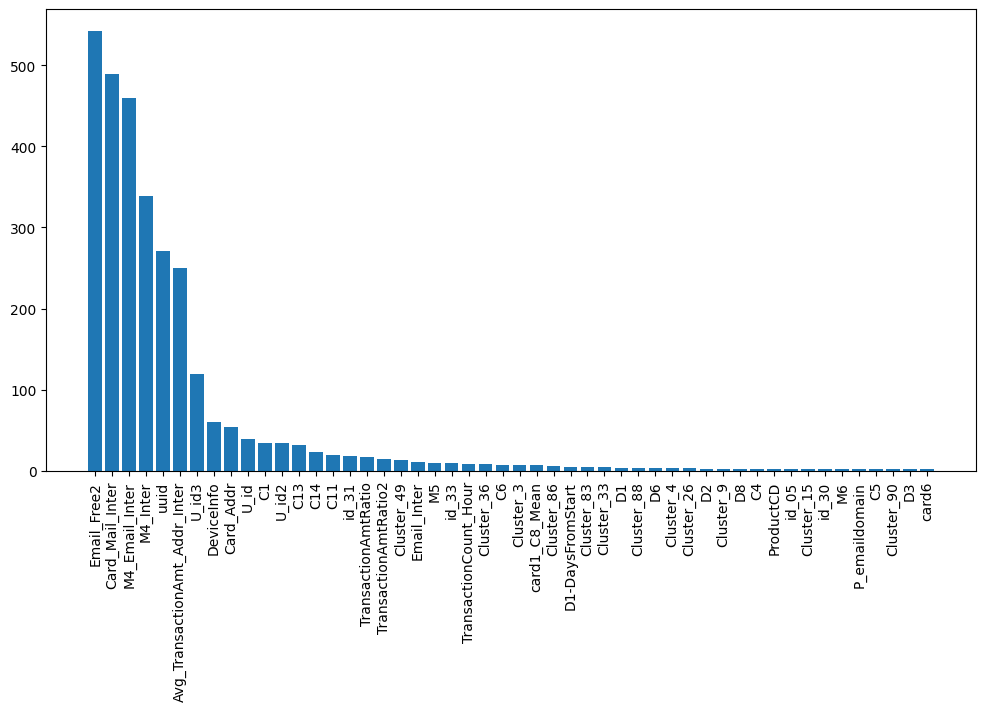

In [ ]:
# Plot top 50 features
features = model.feature_importances_
features = pd.Series(features, index
                     = X_train.columns).sort_values(ascending = False).head(50)
plt.figure(figsize = (12, 6))
plt.bar(features.index, features.values, color = 'slateblue')
plt.xticks(rotation = 90)
plt.title('Top 50 Features by Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.grid('y')
plt.show()

## Correlation Matrice Feature Selection

In [ ]:
# Select numeric columns
data2 = data.copy()
data2 = data.select_dtypes(include = ['number'])

# Shuffle the dataset
data2 = data2.sample(frac = 1, random_state = 42).reset_index(drop = True)

# Define batch size
batch_size = 118_108
batches = [data2[i:i + batch_size] for i in range(0, len(data2), batch_size)]

# Initialize correlation matrix
corr_matrix = np.zeros((data2.shape[1], data2.shape[1]))

# Compute correlation matrix in batches
for batch in batches:
    corr_matrix += np.corrcoef(batch, rowvar = False)

# Average correlation matrix
corr_matrix /= len(batches)

# Select upper triangle of correlation matrix
upper = np.triu(corr_matrix, k = 1)

# Find features with correlation greater than 0.95
to_drop = [column for column,
           idx in zip(data2.columns, range(upper.shape[1]))
           if any(upper[:, idx] > 0.95)]
data2.drop(columns = to_drop, inplace = True)
# Check the result
print('Remaining columns:', data2.columns)

Remaining columns: Index(['TransactionID', 'isFraud', 'TransactionAmt', 'card1', 'card2', 'card3',
       'card5', 'addr1', 'addr2', 'dist1',
       ...
       'Cluster_88', 'Cluster_90', 'Cluster_91', 'Cluster_92', 'Cluster_94',
       'Cluster_95', 'Cluster_96', 'Cluster_97', 'Cluster_98', 'Cluster_99'],
      dtype='object', length=172)


## Lasso Feature Selection

In [ ]:
# Separate features (X) and target (y)
X = data.drop(columns = ['isFraud'])
y = data['isFraud']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include = ['object', 'category']).columns
numerical_cols = X.select_dtypes(include = ['number']).columns

# Apply Label Encoding to categorical columns
label_encoder = LabelEncoder()
for col in categorical_cols:
    X[col] = label_encoder.fit_transform(X[col])

In [ ]:
# Standardize only the numerical columns with batch processing
scaler = StandardScaler()
batch_size = 118_108  # Adjust based on system's memory
X_numerical_scaled = np.zeros_like(X[numerical_cols], dtype = np.float32)

for i in range(0, len(X), batch_size):
    batch = X[numerical_cols].iloc[i:i + batch_size]
    X_numerical_scaled[i:i + batch_size] = scaler.fit_transform(batch)

# Combine scaled numerical columns and label-encoded categorical columns
X_scaled = np.hstack([X_numerical_scaled, X[categorical_cols].values])
X_scaled.shape

(590540, 277)

In [ ]:
# Split into train and test sets (time-based split)
train_size = int(0.8 * len(data))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Handle missing values
imputer = SimpleImputer(strategy = 'mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Initialize Lasso model
lasso = Lasso(alpha = 0.01, random_state = 42)

# Fit the Lasso model
lasso.fit(X_train, y_train)

# Extract the coefficients of the features
lasso_coefs = lasso.coef_

# DataFrame to visualize feature importance
feature_names = numerical_cols.tolist() + categorical_cols.tolist()
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_coefs})

# Sort features by the absolute value of their coefficients
feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values(by = 'Abs_Coefficient',
                                                    ascending = False)

# Display the top features with non-zero coefficients
print('Top Features Selected by Lasso:')
print(feature_importance[feature_importance['Coefficient'] != 0])

Top Features Selected by Lasso:
                           Feature   Coefficient  Abs_Coefficient
224                     Cluster_86  1.526808e-02     1.526808e-02
176                     Cluster_28  9.738279e-03     9.738279e-03
183                     Cluster_36  9.409286e-03     9.409286e-03
22                             C12  8.846603e-03     8.846603e-03
221                     Cluster_83  6.757605e-03     6.757605e-03
151                      Cluster_3  5.746780e-03     5.746780e-03
156                      Cluster_8  4.605761e-03     4.605761e-03
157                      Cluster_9  4.152164e-03     4.152164e-03
187                     Cluster_41  4.077496e-03     4.077496e-03
194                     Cluster_49  2.994078e-03     2.994078e-03
40                           id_01 -5.855301e-04     5.855301e-04
267                    Email_Inter  3.497002e-04     3.497002e-04
257                          id_31  1.469218e-04     1.469218e-04
219                     Cluster_81  1.369372

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.061e+01, tolerance: 1.602e+00
  model = cd_fast.enet_coordinate_descent(


### Lasso V2 w/ Increased alpha

In [ ]:
# Split into train and test sets (time-based split)
train_size = int(0.8 * len(data))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Handle missing values
imputer = SimpleImputer(strategy = 'mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Initialize Lasso model
lasso2 = Lasso(alpha = 0.02, random_state = 42)

# Fit the Lasso model
lasso2.fit(X_train, y_train)

# Extract the coefficients of the features
lasso_coefs2 = lasso2.coef_

# DataFrame to visualize feature importance
feature_names = numerical_cols.tolist() + categorical_cols.tolist()
feature_importance2 = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_coefs2})

# Sort features by the absolute value of their coefficients
feature_importance2['Abs_Coefficient'] = np.abs(feature_importance2['Coefficient'])
feature_importance2 = feature_importance2.sort_values(by = 'Abs_Coefficient',
                                                      ascending = False)

# Display the top features with non-zero coefficients
print('Top Features Selected by Lasso:')
print(feature_importance2[feature_importance2['Coefficient'] != 0])

Top Features Selected by Lasso:
                           Feature   Coefficient  Abs_Coefficient
151                      Cluster_3  1.096648e-02     1.096648e-02
224                     Cluster_86  1.055438e-02     1.055438e-02
183                     Cluster_36  4.964216e-03     4.964216e-03
176                     Cluster_28  1.625909e-03     1.625909e-03
221                     Cluster_83  1.534568e-03     1.534568e-03
267                    Email_Inter  2.094321e-04     2.094321e-04
22                             C12  1.810503e-04     1.810503e-04
258                          id_33 -1.225192e-04     1.225192e-04
274                           U_id  8.838997e-05     8.838997e-05
257                          id_31  8.684898e-05     8.684898e-05
275                          U_id2 -7.814521e-05     7.814521e-05
268                      Card_Addr  3.703824e-05     3.703824e-05
265                     DeviceInfo  3.649145e-06     3.649145e-06
270  Avg_TransactionAmt_Addr_Inter -1.487526

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.704e+00, tolerance: 1.602e+00
  model = cd_fast.enet_coordinate_descent(


In [ ]:
# Define features list based on coefficient threshold
lasso_features1 = ['Cluster_86', 'Cluster_28', 'Cluster_36', 'C12', 'Cluster_83',
                   'Cluster_3', 'Cluster_8', 'Cluster_9', 'Cluster_41', 'Cluster_49',
                   'id_01', 'Email_Inter', 'id_31', 'Cluster_81', 'U_id2', 'id_33',
                   'U_id', 'Card_Addr']

lasso_features2 = ['Cluster_3', 'Cluster_86', 'Cluster_36', 'Cluster_28', 'Cluster_83',
                   'Email_Inter', 'C12', 'id_33', 'U_id', 'id_31', 'U_id2', 'Card_Addr']

# Get the common features
lasso_common = list(set(lasso_features1).intersection(lasso_features2))
lasso_common

['Cluster_3',
 'Email_Inter',
 'id_33',
 'Cluster_83',
 'Cluster_28',
 'C12',
 'Cluster_86',
 'U_id',
 'id_31',
 'U_id2',
 'Card_Addr',
 'Cluster_36']

In [ ]:
# List the features based on LGBM feature importance graph
# Eliminated features already present in Lasso)
lgbm_features = ['Email_Free2', 'Card_Mail_Inter', 'M4_Email_Inter', 'M4_Inter',
                 'uuid', 'Avg_TransactionAmt_Addr_Inter', 'U_id3', 'DeviceInfo',
                 'C1', 'C13', 'C14', 'C11', 'TransactionAmtRatio', 'TransactionDT',
                 'TransactionAmtRatio2', 'Cluster_49', 'M5', 'TransactionCount_Hour',
                 'Cluster_36', 'C6', 'Cluster_3', 'card1_C8_Mean', 'Cluster_86', 'D1-DaysFromStart']
len(lgbm_features)

24

In [ ]:
# Combine Lasso and LGBM features
lasso_lgbm_features = lasso_common + lgbm_features
len(lasso_lgbm_features)

36

In [ ]:
# Find the common features between Lasso + LGBM and Correlation Matrix
correlation_features = data2.columns.to_list()
common2 = list(set(lasso_lgbm_features).intersection(correlation_features))
common2

['D1-DaysFromStart',
 'Cluster_3',
 'C13',
 'Cluster_28',
 'Cluster_83',
 'Cluster_86',
 'Cluster_49',
 'C1',
 'TransactionCount_Hour',
 'Cluster_36']

In [ ]:
# Drop common features from the 'correlation_features'
corr_features = list(set(correlation_features) - set(common2))
corr_features

['Cluster_25',
 'Cluster_30',
 'Cluster_85',
 'id_20',
 'id_07',
 'Cluster_79',
 'Cluster_74',
 'Cluster_23',
 'M4_TransactionAmt_Mean',
 'Cluster_62',
 'Cluster_34',
 'id_03',
 'D5',
 'Cluster_73',
 'Cluster_88',
 'id_09',
 'Cluster_94',
 'Cluster_37',
 'AvgTransactionAmt_Hour',
 'id_01_C7_Mean',
 'Cluster_76',
 'id_32',
 'Cluster_44',
 'C9',
 'Cluster_27',
 'Cluster_12',
 'D1',
 'Cluster_24',
 'D9',
 'Cluster_54',
 'TransactionID',
 'D6',
 'Cluster_4',
 'Cluster_53',
 'Cluster_55',
 'Cluster_66',
 'Cluster_98',
 'card3_C13_Mean',
 'D13',
 'id_11',
 'id_01',
 'Cluster_9',
 'Cluster_45',
 'Cluster_67',
 'card1',
 'Cluster_15',
 'C3',
 'D3',
 'id_13',
 'Cluster_5',
 'C5',
 'Cluster_26',
 'TransactionAmt',
 'Cluster_20',
 'Cluster_22',
 'id_14',
 'Cluster_7',
 'id_02_C14_Mean',
 'Cluster_43',
 'Cluster_65',
 'id_09_C1_Mean',
 'Cluster_97',
 'addr1',
 'D7',
 'Cluster_72',
 'Cluster_96',
 'Cluster_19',
 'id_10',
 'id_25',
 'card3_C1_Mean',
 'Cluster_18',
 'D15',
 'C7',
 'D12',
 'id_17',
 '

In [ ]:
# Create final feature list
# Convert to set and back to list to remove duplicates
final_features = list(set(lasso_lgbm_features + corr_features))
selected_data = data[final_features]
selected_data.shape

(590540, 195)

In [ ]:
selected_data.to_parquet('/content/drive/MyDrive/Colab Notebooks/fraud-detect/data/selected-data-yeto.parquet', engine = 'pyarrow', index = False)

## Undersampling Majority Class

In [ ]:
# Check the target feature label distribution
selected_data['isFraud'].value_counts(normalize = True)

,proportion
isFraud,
0,0.96501
1,0.03499


--> The dataset is severely imbalanced which is common in banking data.  
--> Training model with imbalanced data will introduce bias and limit the generalizability of the model.  
--> To bypass these issues, the majority class will be downsampled. Downsampling is chosen to preserve true nature of the dataset.

In [ ]:
# Separate majority and minority classes
majority_class = selected_data[selected_data['isFraud'] == 0]
minority_class = selected_data[selected_data['isFraud'] == 1]

# Define the desired class distribution
majority_ratio = 0.9  # Majority class 90% of the dataset
minority_ratio = 0.1  # Minority class 10% of the dataset

# Calculate the total number of samples in the final dataset
# Total_samples = number of minority samples / minority_ratio
total_samples = int(len(minority_class) / minority_ratio)

# Calculate the number of majority samples needed
desired_majority_samples = int(total_samples * majority_ratio)

# Randomly sample the majority class to achieve the desired number of samples
# Use random sampling to ensure representativeness
majority_class_undersampled = majority_class.sample(n = desired_majority_samples,
                                                    random_state = 42)

# Combine the undersampled majority class with the minority class
undersampled_data = pd.concat([majority_class_undersampled, minority_class])

# Sort by time to preserve temporal order
undersampled_data = undersampled_data.sort_values(by='TransactionDT')

# Check the class distribution
print('Class distribution after undersampling:')
print(undersampled_data['isFraud'].value_counts(normalize = True))

Class distribution after undersampling:
isFraud
0    0.9
1    0.1
Name: proportion, dtype: float64


In [ ]:
# Analyze temporal gaps between minority and majority classes after downsampling
def analyze_temporal_gaps(data, time_col = 'TransactionDT', target_col = 'isFraud'):

    # Ensure 'TransactionDT' is a datetime column
    if not pd.api.types.is_datetime64_any_dtype(data[time_col]):
        data[time_col] = pd.to_datetime(data[time_col])

    # Calculate the time difference between consecutive transactions
    data['TimeDiff'] = data[time_col].diff()

    # Separate majority and minority classes
    majority = data[data[target_col] == 0]
    minority = data[data[target_col] == 1]

    # Calculate the average time difference for majority and minority classes
    avg_time_diff_majority = majority['TimeDiff'].mean()
    avg_time_diff_minority = minority['TimeDiff'].mean()

    # Check for large gaps between minority and majority classes
    max_time_diff = data['TimeDiff'].max()
    min_time_diff = data['TimeDiff'].min()

    print("\nTemporal Gaps Analysis:")
    print(f"Average time difference (majority): {avg_time_diff_majority}")
    print(f"Average time difference (minority): {avg_time_diff_minority}")
    print(f"Maximum time difference: {max_time_diff}")
    print(f"Minimum time difference: {min_time_diff}")

    # Check if there are any large gaps (e.g., > 1 day)
    large_gaps = data[data['TimeDiff'] > pd.Timedelta(days = 1)]
    if not large_gaps.empty:
        print('\nWarning: Large temporal gaps detected between transactions!')
        print(large_gaps)
    else:
        print('\nNo large temporal gaps detected.')

# Analyze temporal gaps in the undersampled data
analyze_temporal_gaps(undersampled_data)


Temporal Gaps Analysis:
Average time difference (majority): 0 days 00:00:00.000000075
Average time difference (minority): 0 days 00:00:00.000000084
Maximum time difference: 0 days 00:00:00.000008718
Minimum time difference: 0 days 00:00:00

No large temporal gaps detected.


## CatBoost with Optuna

In [ ]:
# Separate features (X) and target (y)
X = undersampled_data.drop(columns = ['isFraud'])
y = undersampled_data['isFraud']

# Identify categorical columns
categorical_cols = X.select_dtypes(include = ['object', 'category']).columns

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
        'depth': trial.suggest_int('depth', 4, 7),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-2, 10.0, log=True),
        'scale_pos_weight': (len(y) - sum(y)) / sum(y),  # Handle class imbalance
        'early_stopping_rounds': 50,  # Early stopping to prevent overfitting
        'verbose': False,
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'task_type': 'GPU',  # Enable GPU acceleration
        'devices': '0:1', 'metric_period': 10000}

    # Perform time-based cross-validation for time-sensitive data
    cv_scores = []
    tscv = TimeSeriesSplit(n_splits = 5)
    for train_idx, val_idx in tscv.split(X):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        # Create CatBoost Pool objects
        train_pool = Pool(X_train_fold, y_train_fold,
                          cat_features = categorical_cols.to_list())
        val_pool = Pool(X_val_fold, y_val_fold,
                        cat_features = categorical_cols.to_list())

        # Train CatBoost model with early stopping
        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set = val_pool, verbose = False,
                  early_stopping_rounds = 50)

        # Evaluate on validation fold
        y_pred_val = model.predict_proba(val_pool)[:, 1]
        cv_scores.append(roc_auc_score(y_val_fold, y_pred_val))

    # Return the mean ROC-AUC score across folds
    return np.mean(cv_scores)

# Run Optuna optimization
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 20)

# Print the best parameters
print('Best parameters:', study.best_params)

[I 2025-02-28 20:35:39,779] A new study created in memory with name: no-name-37ad4692-1c01-41e5-b4e0-84ec58a01f15
[I 2025-02-28 20:37:16,398] Trial 0 finished with value: 0.9224740402077023 and parameters: {'iterations': 855, 'learning_rate': 0.023886780805668646, 'depth': 6, 'l2_leaf_reg': 1.303189217491162, 'random_strength': 1.9538862021094483}. Best is trial 0 with value: 0.9224740402077023.
[I 2025-02-28 20:39:46,379] Trial 1 finished with value: 0.9233949521413368 and parameters: {'iterations': 708, 'learning_rate': 0.017446887174241595, 'depth': 7, 'l2_leaf_reg': 7.2983994443062565, 'random_strength': 2.513152179710074}. Best is trial 1 with value: 0.9233949521413368.
[I 2025-02-28 20:40:28,563] Trial 2 finished with value: 0.9222953303484143 and parameters: {'iterations': 779, 'learning_rate': 0.04551092324762769, 'depth': 4, 'l2_leaf_reg': 0.014674057339976536, 'random_strength': 1.048309663981955}. Best is trial 1 with value: 0.9233949521413368.
[I 2025-02-28 20:41:16,812] Tr

Best parameters: {'iterations': 627, 'learning_rate': 0.015818939331072583, 'depth': 6, 'l2_leaf_reg': 2.1826678402551565, 'random_strength': 0.12486136091411293}


### Performance Evaluation

In [ ]:
# Split the data into train and test sets (time-based split)
train_size = int(0.8 * len(X))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Create CatBoost Pool objects for training and testing
train_pool = Pool(X_train, y_train, cat_features = categorical_cols.to_list())
test_pool = Pool(X_test, y_test, cat_features = categorical_cols.to_list())

# Train the final model with the best hyperparameters
final_model = CatBoostClassifier(**study.best_params)
final_model.fit(train_pool, verbose = False)

# Evaluate on the test set
y_pred_proba = final_model.predict_proba(test_pool)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate evaluation metrics
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Print evaluation metrics
print("Test ROC-AUC Score:", roc_auc)
print("Test Precision-Recall AUC Score:", pr_auc)
print("--*--"*10)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test ROC-AUC Score: 0.9349955089802992
Test Precision-Recall AUC Score: 0.769157715299838
--*----*----*----*----*----*----*----*----*----*--

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     37254
           1       0.93      0.51      0.66      4072

    accuracy                           0.95     41326
   macro avg       0.94      0.75      0.82     41326
weighted avg       0.95      0.95      0.94     41326



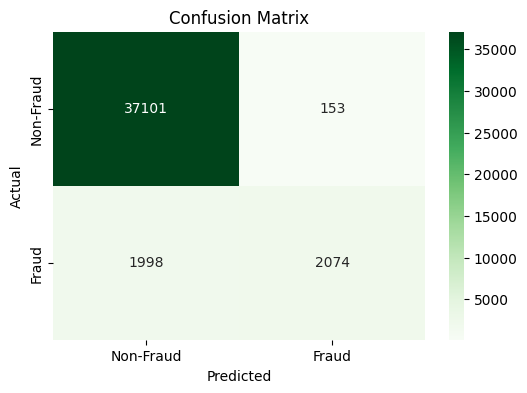

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 4))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Greens',
            xticklabels = ['Non-Fraud', 'Fraud'],
            yticklabels = ['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

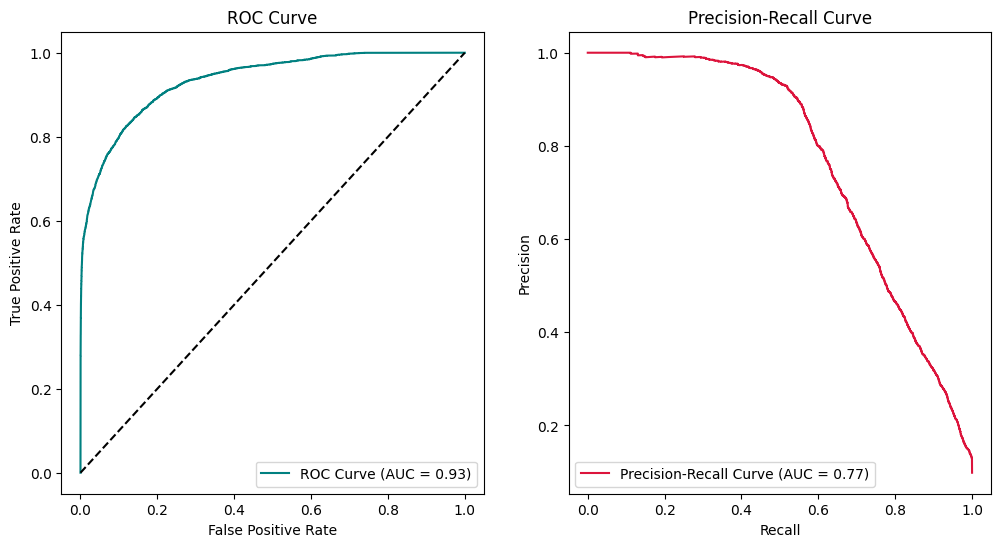

In [ ]:
# Plot ROC curve
fig, axes = plt.subplots(1, 2, figsize = (12, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color = 'teal')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()

# Plot Precision-Recall curve
axes[1].plot(recall, precision,
             label = f'Precision-Recall Curve (AUC = {pr_auc:.2f})',
             color = 'crimson')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()
plt.show()

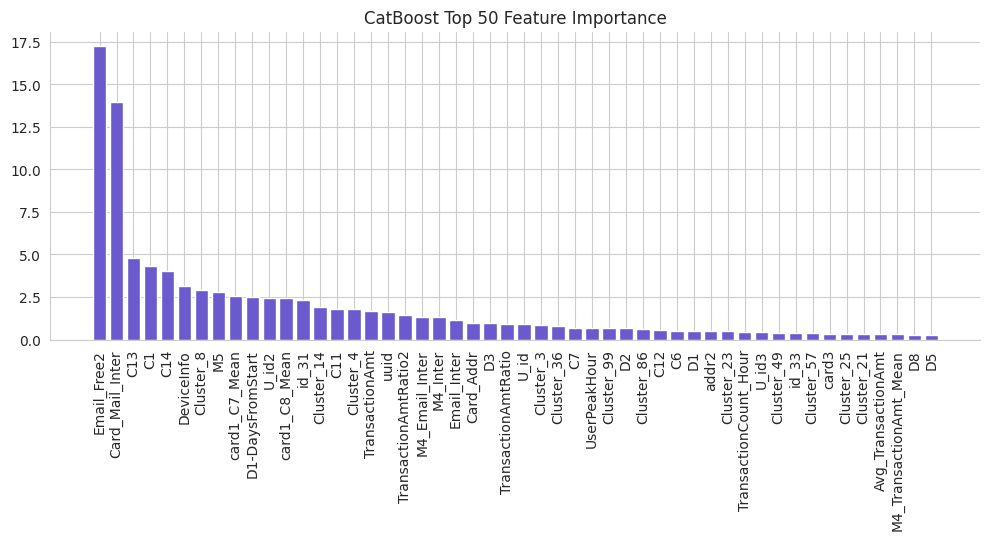

In [ ]:
feature_importance = pd.DataFrame({'feature_importance': final_model.get_feature_importance(train_pool),
                                   'feature_names': X_train.columns})
feature_importance = feature_importance[feature_importance['feature_importance'] > 0].sort_values(by = 'feature_importance', ascending = False)
plt.figure(figsize = (12, 4))
plt.bar(feature_importance['feature_names'].head(50),
        feature_importance['feature_importance'].head(50), color = 'slateblue')
plt.xticks(rotation = 90)
plt.title('CatBoost Top 50 Feature Importance')
plt.grid('y')
sns.despine()
plt.show()

## CatBoost with Optuna V2

In [ ]:
# Separate features (X) and target (y)
X = undersampled_data.drop(columns = ['isFraud'])
y = undersampled_data['isFraud']

# Identify categorical columns
categorical_cols = X.select_dtypes(include = ['object', 'category']).columns

In [ ]:
scale_pos_weight = (len(y) - sum(y)) / sum(y)  # majority/minority class

def objective2(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-2, 10.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight',
                                                scale_pos_weight * 0.5,
                                                scale_pos_weight * 2),
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'early_stopping_rounds': 50,
        'verbose': False,
        'task_type': 'GPU',
        'devices': '0:1', 'metric_period': 10000}

    # Perform time-based cross-validation
    cv_scores = []
    tscv = TimeSeriesSplit(n_splits = 5)
    for train_idx, val_idx in tscv.split(X):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        # Create CatBoost Pool objects
        train_pool = Pool(X_train_fold, y_train_fold,
                          cat_features = categorical_cols.to_list())
        val_pool = Pool(X_val_fold, y_val_fold,
                        cat_features = categorical_cols.to_list())

        # Train CatBoost model with early stopping
        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set = val_pool,
                  verbose = False, early_stopping_rounds = 50)

        # Evaluate on validation fold
        y_pred_val = model.predict_proba(val_pool)[:, 1]
        cv_scores.append(roc_auc_score(y_val_fold, y_pred_val))

    # Return the mean ROC-AUC score across folds
    return np.mean(cv_scores)

# Run Optuna optimization
study2 = optuna.create_study(direction = 'maximize')
study2.optimize(objective2, n_trials = 12)

# Print the best parameters
print('Best parameters2:', study2.best_params)

[I 2025-02-28 21:55:04,136] A new study created in memory with name: no-name-59495a03-f487-4d03-9c1a-25cf6afac9be
[I 2025-02-28 21:56:03,906] Trial 0 finished with value: 0.9159982982860445 and parameters: {'iterations': 1915, 'learning_rate': 0.07074879183136391, 'depth': 8, 'l2_leaf_reg': 0.2618112032369601, 'random_strength': 0.7437800602210366, 'scale_pos_weight': 17.912242200923032}. Best is trial 0 with value: 0.9159982982860445.
[I 2025-02-28 21:56:38,135] Trial 1 finished with value: 0.9160009575841046 and parameters: {'iterations': 1878, 'learning_rate': 0.19915254012208766, 'depth': 8, 'l2_leaf_reg': 5.291583228964113, 'random_strength': 0.5237609296066892, 'scale_pos_weight': 15.35775367423493}. Best is trial 1 with value: 0.9160009575841046.
[I 2025-02-28 21:58:50,381] Trial 2 finished with value: 0.9185724948127361 and parameters: {'iterations': 815, 'learning_rate': 0.06942211209261068, 'depth': 10, 'l2_leaf_reg': 9.599325664184022, 'random_strength': 3.345665597078866, '

Best parameters2: {'iterations': 1215, 'learning_rate': 0.030621871654355783, 'depth': 5, 'l2_leaf_reg': 3.181558491601218, 'random_strength': 3.759912614917542, 'scale_pos_weight': 9.08150346652263}


In [ ]:
# Split the data into train and test sets (time-based split)
train_size = int(0.8 * len(X))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Create CatBoost Pool objects for training and testing
train_pool = Pool(X_train, y_train, cat_features = categorical_cols.to_list())
test_pool = Pool(X_test, y_test, cat_features = categorical_cols.to_list())

# Train the final model with the best hyperparameters
final_model2 = CatBoostClassifier(**study2.best_params)
final_model2.fit(train_pool, verbose = False)

# Evaluate on the test set
y_pred_proba = final_model2.predict_proba(test_pool)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

# Calculate evaluation metrics
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Print evaluation metrics
print("Test ROC-AUC Score:", roc_auc)
print("Test Precision-Recall AUC Score:", pr_auc)
print("--*--"*10)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test ROC-AUC Score: 0.9377018282500327
Test Precision-Recall AUC Score: 0.7706138987594071
--*----*----*----*----*----*----*----*----*----*--

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94     37254
           1       0.49      0.80      0.60      4072

    accuracy                           0.90     41326
   macro avg       0.73      0.85      0.77     41326
weighted avg       0.93      0.90      0.91     41326



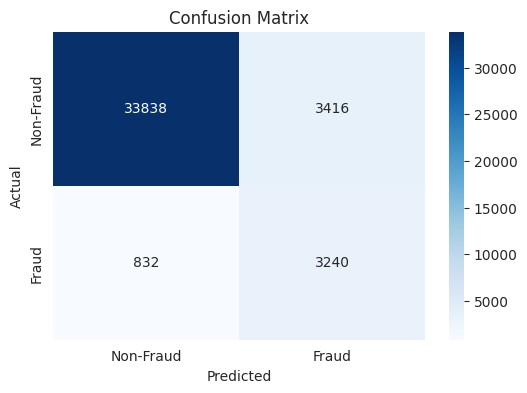

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 4))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues',
            xticklabels = ['Non-Fraud', 'Fraud'],
            yticklabels = ['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Save Trained CatBoost

In [ ]:
# Save the model
model_filename = '/content/drive/MyDrive/Colab Notebooks/fraud-detect/catboost_model2.cbm'
final_model2.save_model(model_filename)

## CatBoost without undersampling

In [ ]:
# Separate features (X) and target (y)
X = selected.drop(columns = ['isFraud'])
y = selected['isFraud']

# Identify categorical columns
categorical_cols = X.select_dtypes(include = ['object', 'category']).columns

# majority/minority class
scale_pos_weight = (len(y) - sum(y)) / sum(y)

In [ ]:
scale_pos_weight = (len(y) - sum(y)) / sum(y)  # majority/minority class

def objective3(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-2, 10.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight',
                                                scale_pos_weight * 0.5,
                                                scale_pos_weight * 2),
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'early_stopping_rounds': 50,
        'verbose': False,
        'task_type': 'GPU',
        'devices': '0:1', 'metric_period': 10000}

    # Perform time-based cross-validation
    cv_scores = []
    tscv = TimeSeriesSplit(n_splits = 5)
    for train_idx, val_idx in tscv.split(X):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        # Create CatBoost Pool objects
        train_pool = Pool(X_train_fold, y_train_fold,
                          cat_features = categorical_cols.to_list())
        val_pool = Pool(X_val_fold, y_val_fold,
                        cat_features = categorical_cols.to_list())

        # Train CatBoost model with early stopping
        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set = val_pool,
                  verbose = False, early_stopping_rounds = 50)

        # Evaluate on validation fold
        y_pred_val = model.predict_proba(val_pool)[:, 1]
        cv_scores.append(roc_auc_score(y_val_fold, y_pred_val))

    # Return the mean ROC-AUC score across folds
    return np.mean(cv_scores)

# Run Optuna optimization
study3 = optuna.create_study(direction = 'maximize')
study3.optimize(objective3, n_trials = 20)

# Print the best parameters
print('Best parameters3:', study3.best_params)

[I 2025-03-02 21:48:56,952] A new study created in memory with name: no-name-672ab86c-8f9a-4fd7-a51c-228c12056128
[I 2025-03-02 21:50:11,417] Trial 0 finished with value: 0.9297424337197822 and parameters: {'iterations': 627, 'learning_rate': 0.12092849947954301, 'depth': 4, 'l2_leaf_reg': 0.3566206743923763, 'random_strength': 0.021723895989061482, 'scale_pos_weight': 20.90386217606183}. Best is trial 0 with value: 0.9297424337197822.
[I 2025-03-02 21:54:19,545] Trial 1 finished with value: 0.9346612701457714 and parameters: {'iterations': 1237, 'learning_rate': 0.03373431114021464, 'depth': 6, 'l2_leaf_reg': 5.9352175624998695, 'random_strength': 4.558182993781433, 'scale_pos_weight': 17.020345150284438}. Best is trial 1 with value: 0.9346612701457714.
[I 2025-03-02 21:56:06,769] Trial 2 finished with value: 0.9074926631751629 and parameters: {'iterations': 1066, 'learning_rate': 0.058117218413508975, 'depth': 10, 'l2_leaf_reg': 0.05862206569173954, 'random_strength': 9.3477474458740

Best parameters3: {'iterations': 1237, 'learning_rate': 0.03373431114021464, 'depth': 6, 'l2_leaf_reg': 5.9352175624998695, 'random_strength': 4.558182993781433, 'scale_pos_weight': 17.020345150284438}


In [ ]:
# Split the data into train and test sets (time-based split)
train_size = int(0.8 * len(X))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Create CatBoost Pool objects for training and testing
train_pool = Pool(X_train, y_train, cat_features = categorical_cols.to_list())
test_pool = Pool(X_test, y_test, cat_features = categorical_cols.to_list())

# Train the final model with the best hyperparameters
final_model3 = CatBoostClassifier(iterations = 1237, learning_rate = 0.0337,
                                  depth = 6, l2_leaf_reg = 5.9352,
                                  random_strength = 4.5582, scale_pos_weight = 17.0203,
                                  loss_function = 'Logloss',
                                  eval_metric = 'AUC',
                                  verbose = False,
                                  task_type = 'GPU',
                                  devices = '0:1', metric_period = 10000)
final_model3.fit(train_pool, early_stopping_rounds = 50, verbose = False)

# Evaluate on the test set
y_pred_proba = final_model3.predict_proba(test_pool)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

# Calculate evaluation metrics
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Print evaluation metrics
print("Test ROC-AUC Score:", roc_auc)
print("Test Precision-Recall AUC Score:", pr_auc)
print("--*--"*10)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test ROC-AUC Score: 0.9425599448320403
Test Precision-Recall AUC Score: 0.6461407914362267
--*----*----*----*----*----*----*----*----*----*--

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96    114044
           1       0.29      0.77      0.42      4064

    accuracy                           0.93    118108
   macro avg       0.64      0.85      0.69    118108
weighted avg       0.97      0.93      0.94    118108

